# Companion Notebook
This notebook contains all the code for all the experiments mentioned in the blog. 

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

THINKING_TIME = 100

In [97]:
def gen_rand_states(num_states, num_nodes):
    rng = np.random.default_rng()
    rand_states = rng.integers(low=0, high=2, size=(num_states, num_nodes))
    return rand_states

def process_results(res, memories):
    labels = []
    ghost_mems = np.logical_not(memories).astype(int)
    all_mems = np.append(memories, ghost_mems, axis=0) 
    spur_mems = np.array([], dtype=int)

    for k,v in res.items():
        for i, mem in enumerate(all_mems):
            eq = np.array_equal(v['recalled_mem'], mem)
            if eq:
                labels.append(f'mem_{i+1}')
                break
        else:
            if spur_mems.size == 0:
                spur_mems = v['recalled_mem'].reshape(1, -1)
                labels.append('spur_mem_0')
            else:
                idx_arr = np.nonzero((spur_mems==v['recalled_mem']).all(1))[0]
                if idx_arr.size != 0:
                    idx = idx_arr[0]
                    labels.append(f'spur_mem_{idx}')    
                else:
                    spur_mem_idx = spur_mems.shape[0]
                    labels.append(f'spur_mem_{spur_mem_idx}')
                    spur_mems = np.append(spur_mems, [v['recalled_mem']], axis=0)

    return labels



class HopfieldNetwork:
    def __init__(self, thinking_time, num_nodes, memories = None):
        self.results = {}
        self.stopping_step = []
        self.rng = np.random.default_rng()
        
        self.memories = memories
        self.num_nodes = num_nodes
        self.thinking_time = thinking_time

        self.calc_mem_weights = self.calc_bin_mem_weights
        if memories is not None:
            self.W = self.fit()
        else:
            self.W = self.rng.uniform(-1, 1, size=(self.num_nodes, self.num_nodes))

    def fit(self):
        W = np.zeros((self.num_nodes, self.num_nodes))
        for mem in self.memories:
            W += self.calc_mem_weights(mem)

        return W

    def calc_bin_mem_weights(self, mem):
        x = 2*mem - 1
        mem_w = x.reshape((-1, 1))@x.reshape((1, -1))
        np.fill_diagonal(mem_w, 0)
        return mem_w

    def calc_bip_mem_weights(self, mem):
        mem_w = mem.reshape((-1, 1))@mem.reshape((1, -1))
        np.fill_diagonal(mem_w, 0)
        return mem_w
    
    def sync_remember_(self, mem):
        mem_prev = mem.copy()
        mem_energies = [11111111]

        for t in (range(self.thinking_time)):
            local_fields = self.W@mem
            mem[local_fields>0] = 1
            mem[local_fields<0] = 0

            stop = np.equal(mem, mem_prev).all()
            if stop:
                # print('stopping at', t)
                self.stopping_step.append(t)
                break
            else:
                mem_prev = mem.copy()

        else:
            self.stopping_step.append(t)

        return mem, mem_energies
    
    def stringify_mem(self, mem):
        return ''.join(mem.astype(str))
    
    def remember_(self, mem):
        mem_prev = mem.copy()
        idxs_ = np.arange(len(mem))
        evolution = []

        for t in (range(self.thinking_time)):
            self.rng.shuffle(idxs_)
            for i in idxs_:
                i_local_field = np.dot(self.W[i][:], mem)

                if i_local_field > 0:
                    mem[i] = 1
                elif i_local_field < 0:
                    mem[i] = 0


            t_data = {
                't_mem': mem.copy(),
                'mem_str': self.stringify_mem(mem),
                'energy': self.calc_energy(mem)
            }
            evolution.append(t_data)
            stop = np.equal(mem, mem_prev).all()
            if stop:
                # print('stopping at', t)
                self.stopping_step.append(t)
                break
            else:
                mem_prev = mem.copy()

        else:
            self.stopping_step.append(t)

        res = {
            'recalled_mem': mem,
            'evolution': evolution
        }

        return res
    

    def remember(self, mem_cues: list):
        '''
        calls `remember_` for each mem cue, fill the `results` dict and returns it.
        '''
        for i, mem_cue in tqdm(enumerate(mem_cues), total=len(mem_cues)):
            res = self.remember_(mem_cue.copy())
            res['mem_cue'] = mem_cue
            
            self.results[i] = res

        #     print('.', end='')
        # else:
        #     print()
        
        return self.results   

    def calc_energy(self, mem):
        energy = -(mem@(self.W@mem))
        return energy

    def match_memories(self, mem1, mem2):
        return (mem1==mem2).sum()/self.num_nodes

### Experiment-1
num_memory = 1

result:<br>
both memory and ghost memory states are recalled all the time but their proportion depends on the proportion of 1's, 0's in the memory. If number of 1's are greater than number of 0's in the memory then proportion of "memories" recalled is greater than "ghost memories" and vice versa.

In [12]:
num_memories = 1
num_nodes = 30
num_init_states = 1000

memories = gen_rand_states(num_memories, num_nodes)
init_states = gen_rand_states(num_init_states, num_nodes)

model = HopfieldNetwork(THINKING_TIME, num_nodes, memories)
res = model.remember(init_states)

print('Memories:')
print(memories, end='\n\n')

print('Number of 1\'s in the memory: ', (memories==1).sum(), '\n\n')

print('Some stats:')
labels = process_results(res, memories)
print(len(labels))
print(np.unique(labels, return_counts=True), end='\n\n')

print('Recalled Memories:')
for k,v in res.items():
    print(v['recalled_mem'])

100%|██████████| 1000/1000 [00:00<00:00, 3990.29it/s]


Memories:
[[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]]

Number of 1's in the memory:  15 


Some stats:
1000
(array(['mem_1', 'mem_2'], dtype='<U5'), array([486, 514], dtype=int64))

Recalled Memories:
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 

### Experiment-2
num_memory = 2

result:<br/>All init states resulted into one of 4 total memories (which includes 2 ghost memories). Again the proportion among the 4 recalled memories depends on the proportion of 1's, 0's in the respective stored memories.

When you run this cell multiple times, sometimes (rarely) it would occur that one of the init states gets evolved to a spurious memory. So, this experiment also shows how spuroious memory exists when more than 1 user memories are stored. 

In [109]:
num_memories = 2
num_nodes = 30
num_init_states = 1000

memories = gen_rand_states(num_memories, num_nodes)
init_states = gen_rand_states(num_init_states, num_nodes)

model = HopfieldNetwork(THINKING_TIME, num_nodes, memories)
res = model.remember(init_states)

print('Memories:')
print(memories, end='\n\n')

print('Some stats:')
labels = process_results(res, memories)
print(len(labels))
print(np.unique(labels, return_counts=True), end='\n\n')

print('Recalled Memories:')
for k,v in res.items():
    print(v['recalled_mem'] )

100%|██████████| 1000/1000 [00:00<00:00, 2660.06it/s]


Memories:
[[1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]]

Some stats:
1000
(array(['mem_1', 'mem_2', 'mem_3', 'mem_4', 'spur_mem_0'], dtype='<U10'), array([231, 136, 261, 370,   2], dtype=int64))

Recalled Memories:
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1]
[1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0]
[0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1]
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]
[1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0]
[0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1]
[1 1 1 1 0 1 1 1 0 1 1

In [28]:
labels = process_results(res, memories)
print(len(labels))
print(np.unique(labels, return_counts=True), end='\n\n')

1000
(array(['mem_1', 'mem_2', 'mem_3', 'mem_4', 'spur_mem'], dtype='<U8'), array([386,   3,  11, 599,   1], dtype=int64))



In [41]:
for k,v in res.items():
    pass

In [42]:
v['recalled_mem']

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1], dtype=int64)

### Experiment-3
Asymmetric W

Results: <br/>
1. Different W leads to different behaviour. Some W have stable states while others do not.
2. Didn't found a nice distribution over some small set of states where network revolves if it do not settle, rather every state is almost unique but with shorter hamming distance. (ain't this chaotic wandering around a state)

TODO: <br/>
1. need to calculate entropy
2. need to find alternating behavior, which I didn't find.


In [56]:
num_init_states = 1000
num_nodes = 30
init_states = gen_rand_states(num_init_states, num_nodes)

model = HopfieldNetwork(THINKING_TIME, num_nodes)

res = model.remember(init_states)

print('Stopping step stats:')
print(min(model.stopping_step), max(model.stopping_step))

# print('Recalled Memories:')
# for k,v in res.items():
#     print(v['recalled_mem'], v['HAHA'], )

100%|██████████| 1000/1000 [00:12<00:00, 78.92it/s]

Stopping step stats:
99 99


In [57]:
np.unique(model.stopping_step, return_counts=True)

(array([99]), array([1000], dtype=int64))

In [ ]:
## this confirms that there is no nice distribution in a evolution. Max frequency is so small.
for i in range(THINKING_TIME):
    _, counts = np.unique([d['mem_str'] for d in res[i]['evolution']], return_counts=True)
    print(counts.max(), end=', ')

2, 1, 2, 2, 3, 3, 2, 3, 1, 3, 1, 2, 1, 3, 1, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 4, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2, 1, 2, 

In [61]:
for i in range(THINKING_TIME):
    evol_mem = np.array([d['t_mem'] for d in res[3]['evolution']])
    hamm_mat = (evol_mem[:, None, :] != evol_mem).sum(2)
    print(hamm_mat.max())

18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18


(array([10.,  0., 10., 12., 26., 14., 14.,  4.,  8.,  2.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

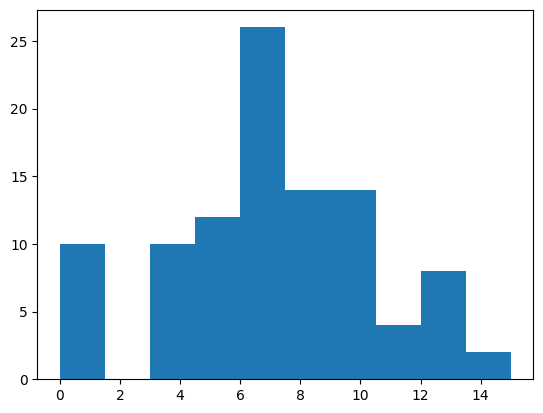

In [73]:
plt.hist(hamm_mat[:10, :10].flatten())


(array([ 174.,  448., 1266., 2398., 1430., 2366., 1262.,  504.,  142.,
          10.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

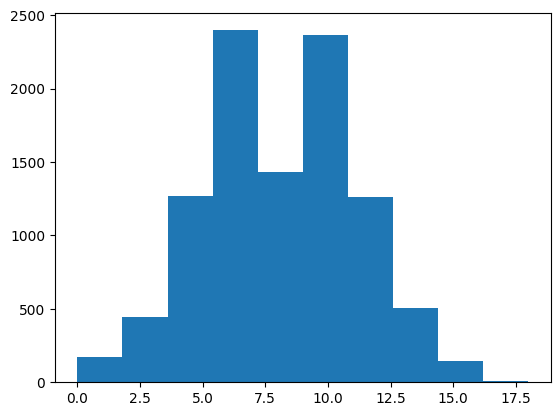

In [ ]:
# although every state is unique in the evolution but this confirms that states evolves in a small region of state space only. 
plt.hist(hamm_mat.flatten())

In [76]:
(hamm_mat==0).sum()

102

In [ ]:
# this confirms that different Ws have different bahavior: some have stable states while others dont.

t_states = 1000
num_nodes = 30
init_states = gen_rand_states(num_init_states, num_nodes)

t = []
Ws = []

for _ in (range(10)):
    model = HopfieldNetwork(THINKING_TIME, num_nodes)
    res = model.remember(init_states)
    t.append(min(model.stopping_step))
    Ws.append(model.W)

100%|██████████| 1000/1000 [00:12<00:00, 78.54it/s]


In [6]:
np.unique(t, return_counts=True)

(array([ 1,  2, 99]), array([2, 2, 6], dtype=int64))

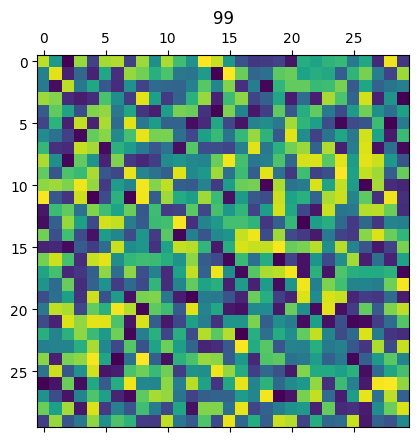

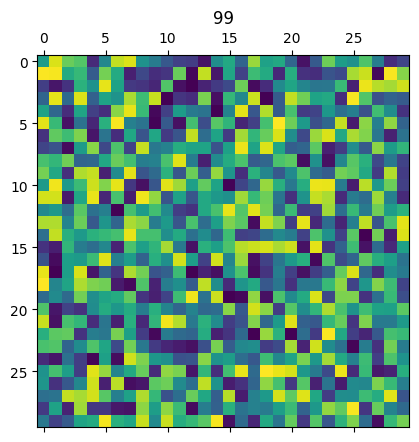

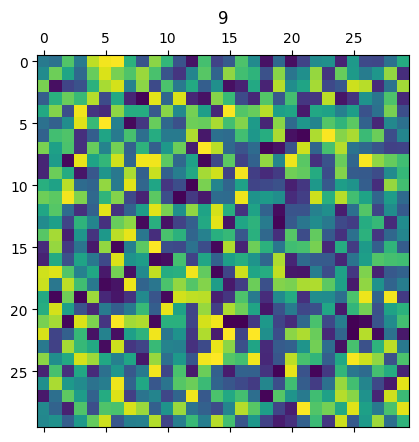

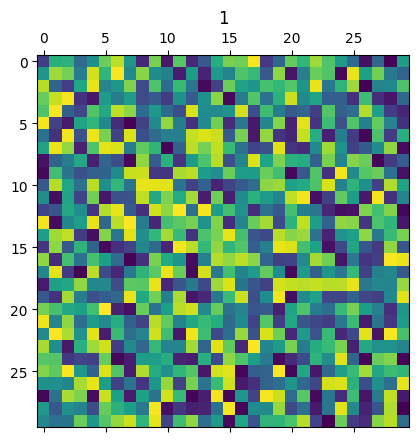

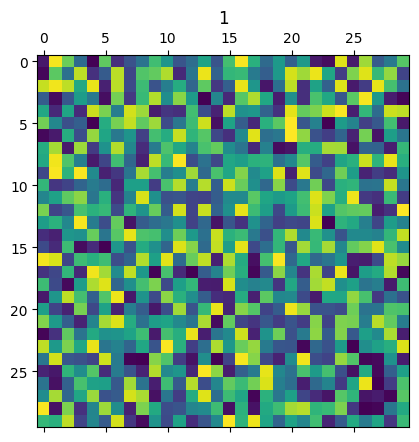

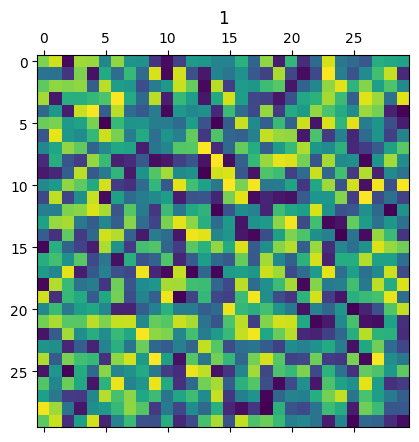

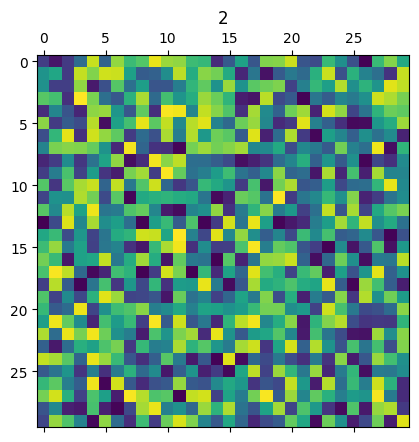

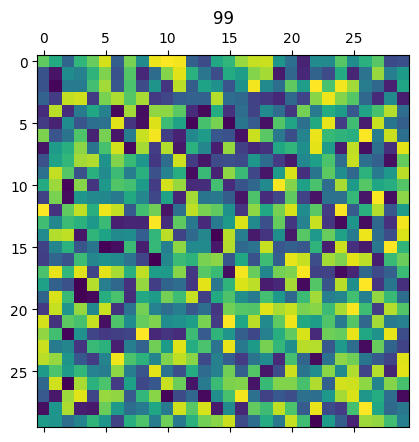

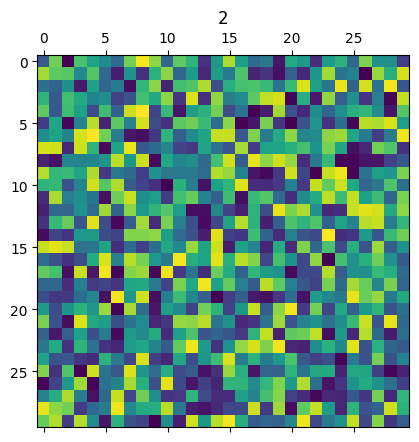

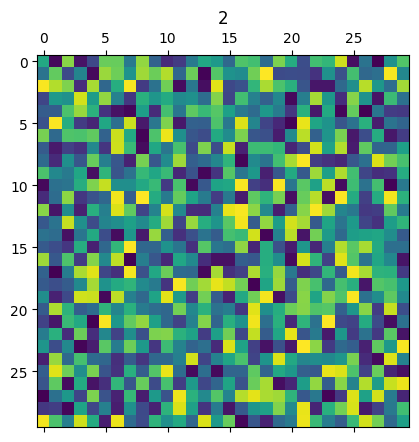

In [61]:
import matplotlib.pyplot as plt

for m, W in zip(t, Ws):
    plt.matshow(W)
    plt.title(m)
    plt.show()

### Experiment-4
Capacity Testing

100%|██████████| 5/5 [00:00<00:00, 492.60it/s]


Some stats:
num_memories :  5 num_memories_stable :  5
['mem_1' 'mem_2' 'mem_3' 'mem_4' 'mem_5'] [1 1 1 1 1]


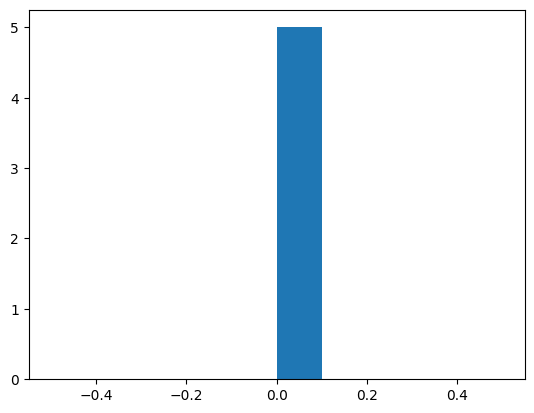

100%|██████████| 10/10 [00:00<00:00, 377.75it/s]

Some stats:
num_memories :  10 num_memories_stable :  9
['mem_1' 'mem_10' 'mem_2' 'mem_3' 'mem_4' 'mem_5' 'mem_6' 'mem_7' 'mem_9'] [1 1 1 1 1 1 1 1 1]


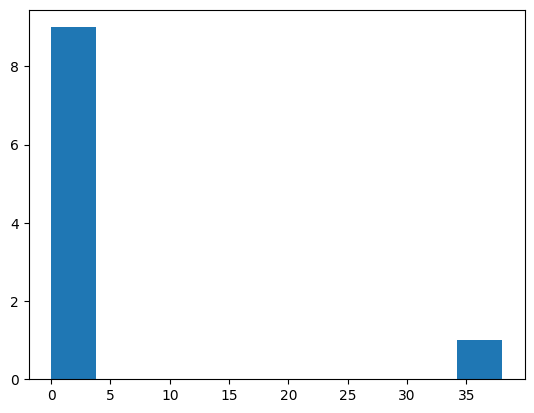

100%|██████████| 15/15 [00:00<00:00, 87.19it/s]


Some stats:
num_memories :  15 num_memories_stable :  3
['mem_1' 'mem_10' 'mem_15'] [1 1 1]


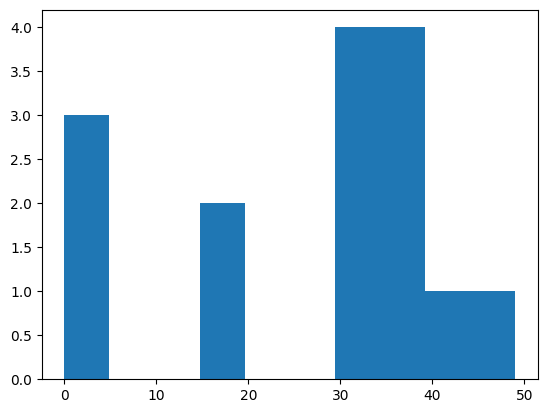

In [6]:
### graphs similar to paper, but middle one varies a lot (n=10)

def process_results_exp4(res):
    proc_res = {}
    hamm_dists = []

    for k,v in res.items():
        eq = np.array_equal(v['recalled_mem'], v['mem_cue'])
        hamm_dist = (v['recalled_mem'] != v['mem_cue']).sum()
        proc_res[k] = {'is_stable': eq, 'hamm_dist': hamm_dist}

        hamm_dists.append(hamm_dist)

    return hamm_dists

num_nodes = 100
# num_init_states = 1000

for num_memories in [5, 10, 15]:
    memories = gen_rand_states(num_memories, num_nodes)
    # init_states = gen_rand_states(num_init_states, num_nodes)

    model = HopfieldNetwork(THINKING_TIME, num_nodes, memories)
    res = model.remember(memories)

    print('Some stats:')
    labels = process_results(res, memories)
    uniq_labels, uni_lab_counts = np.unique(labels, return_counts=True)
    print('num_memories : ', num_memories, 'num_memories_stable : ', len(uniq_labels))
    print(uniq_labels, uni_lab_counts, end='\n')
    print('='*30)

    proc_res = process_results_exp4(res)
    plt.hist(proc_res)
    plt.show()


In [ ]:
# running n=15 for multiple iterations 

for num_memories in [5, 10, 15]:
    memories = gen_rand_states(num_memories, num_nodes)
    # init_states = gen_rand_states(num_init_states, num_nodes)

    model = HopfieldNetwork(THINKING_TIME, num_nodes, memories)
    res = model.remember(memories)

    print('Some stats:')
    labels = process_results(res, memories)
    uniq_labels, uni_lab_counts = np.unique(labels, return_counts=True)
    print('num_memories : ', num_memories, 'num_memories_stable : ', len(uniq_labels))
    print(uniq_labels, uni_lab_counts, end='\n')
    print('='*30)

    proc_res = process_results_exp4(res)
    plt.hist(proc_res)
    plt.show()

In [63]:
(res[0]['mem_cue'] != res[0]['mem_cue']).sum()

0